In [1]:
import os
import requests
import pandas as pd
import numpy as np

from statistics import mean, stdev
from haversine import haversine, Unit

import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from matplotlib import colors
import seaborn as sns; sns.set(style="ticks", color_codes=True)

import time

processing_time = time.time()

# US Cities Database

From [US Cities Database - SimpleMaps](https://simplemaps.com/data/us-cities)

In [2]:
towns = pd.read_csv('./data/simplemaps_uscities_basicv1.74/uscities.csv')

display(towns.head(2))
print(f"Total Number of Towns and Cities: {towns.shape}")

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715,polygon,False,True,America/New_York,1,11229 11226 11225 11224 11222 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,3276,polygon,False,True,America/Los_Angeles,1,90291 90293 90292 91316 91311 90037 90031 9000...,1840020491


Total Number of Towns and Cities: (28337, 17)


In [3]:
# Reduce the Dimensionality of the Town Data
relevant_stats = [
    'city',
    'state_id',
    'lat',
    'lng',
    'population',
    'density'
]

# Filter Properties to Needed Columns
towns = towns[relevant_stats]
print(f"Total Number of Towns and Cities: {towns.shape}")

Total Number of Towns and Cities: (28337, 6)


In [4]:
# Rename Columns for Lat and Long to follow Paper's Standard
column_names = {
    'lat': 'ylat', 
    'lng': 'xlong'
}

towns = towns.rename(columns=column_names)

In [5]:
'''
Function to find the nearest towns to a specific target
    - Params:
        - turbine : one turbine row from dataframe
        - towns : df of towns to search through
    - Return:
        - list[tuple] : tuples (town_idx, distance) of distances to each other town in the df provided
'''
def find_nearest_towns(target, towns):
    xlong_target = target['xlong']
    ylat_target = target['ylat']
    
    # Store Index and Distance for each Town
    town_idxs = []
    town_distances = []
    
    # Loop foreach Town
    for idx_town, xlong_town, ylat_town  in towns[['xlong','ylat']].itertuples():
        distance = haversine((ylat_target, xlong_target), (ylat_town, xlong_town), unit=Unit.MILES)
        # Add to Lists
        town_idxs.append(idx_town)
        town_distances.append(distance)
        
    # Sort the Towns based on Distance in Decending Order
    sorted_towns = sorted(zip(town_idxs, town_distances), key=lambda x:x[1])
    
    # List of Sorted Tuples
    return sorted_towns


In [6]:
'''
Function to find the nearest town to a specific target
    - Params:
        - turbine : one turbine row from dataframe
        - towns : df of towns to search through
    - Return:
        - town_idx : Index of town that is nearest to the given Turbine
'''
def find_nearest_town(target, towns):
    # Find the Towns based on Distance in Decending Order
    sorted_towns = find_nearest_towns(target=target, towns=towns)
    
    # Return Town Index of Nearest Town
    return sorted_towns[0][0]

In [7]:
%%time 

towns['neighbors'] = ''

# Create a Graph between Cities 
# Loop for each Town
for town_idx, row in towns.iterrows():
    # Filter Towns within the Given State
    state_towns = towns[towns['state_id'] == row['state_id']]
    
    # Find Nearest Towns
    sorted_towns = find_nearest_towns(target=row, towns=state_towns)

    # Find Nearest 5 Towns
    nearest_town_idxs = [str(tup[0]) for tup in sorted_towns[1:5]]
    
    # Set Neighbors
    towns.loc[[town_idx], 'neighbors'] = '|'.join(nearest_town_idxs)
    

CPU times: user 4min 51s, sys: 4.39 s, total: 4min 55s
Wall time: 5min 8s


In [8]:
display(towns.head(2))
print(f"Total Number of Towns and Cities: {towns.shape}")

,city,state_id,ylat,xlong,population,density,neighbors
0,New York,NY,40.6943,-73.9249,18713220,10715,18|34|19|4192
1,Los Angeles,CA,34.1139,-118.4068,12750807,3276,1457|1342|447|1253


Total Number of Towns and Cities: (28337, 7)


---
# Wind Energy Production

From [Energy Information Administration](https://www.eia.gov/electricity/data/state/)

In [9]:
# Load CSV of Energy Generation by State
df = pd.read_csv('./data/annual_generation_state.csv')

display(df.head())
print(f"Total Production Records: {df.shape}")

,YEAR,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
0,1990,AK,Total Electric Power Industry,Total,5599506.0
1,1990,AK,Total Electric Power Industry,Coal,510573.0
2,1990,AK,Total Electric Power Industry,Hydroelectric Conventional,974521.0
3,1990,AK,Total Electric Power Industry,Natural Gas,3466261.0
4,1990,AK,Total Electric Power Industry,Petroleum,497116.0


Total Production Records: (55885, 5)


In [10]:
# Select the Most Recent Data, For Wind Power, Totaled for Each State
df = df[(df['ENERGY SOURCE']=='Wind') & (df['YEAR']==2020) & (df['TYPE OF PRODUCER']=='Total Electric Power Industry')]

display(df.head())
print(f"Total Current Wind Records: {df.shape}")

,YEAR,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
53763,2020,AK,Total Electric Power Industry,Wind,128533.0
53875,2020,AZ,Total Electric Power Industry,Wind,644160.0
53913,2020,CA,Total Electric Power Industry,Wind,13583089.0
53974,2020,CO,Total Electric Power Industry,Wind,13386228.0
54021,2020,CT,Total Electric Power Industry,Wind,12184.0


Total Current Wind Records: (42, 5)


In [11]:
# Reduce the Dimensionality of the Town Data
relevant_stats = [
    'STATE',
    'GENERATION (Megawatthours)'
]

# Filter Properties to Needed Columns
df = df[relevant_stats]

In [12]:
 # Rename Columns for Lat and Long to follow Paper's Standard
column_names = {
    'STATE': 'state_id', 
    'GENERATION (Megawatthours)': 'state_wind_gen_MWh'
}

df = df.rename(columns=column_names)

In [13]:
# Estimate Production for remaining States
towns = towns.merge(df, how='left', on='state_id')

towns['state_wind_gen_MWh'].fillna(value=towns['state_wind_gen_MWh'].mean(), inplace=True)

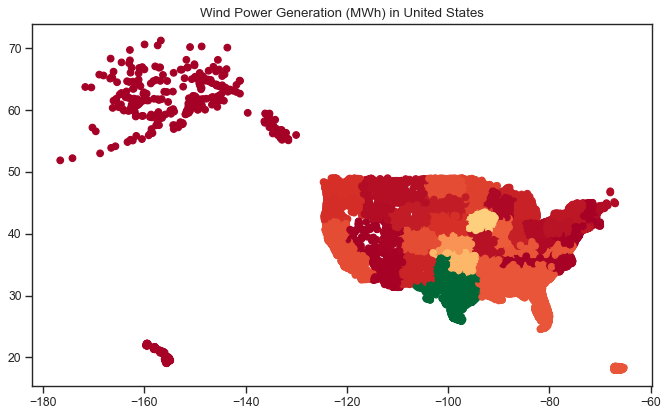

In [14]:
# Plot Towns 
figure(figsize=(10, 6), dpi=80)
plt.scatter(x=towns['xlong'], y=towns['ylat'], c=towns['state_wind_gen_MWh'], cmap='RdYlGn')
plt.title("Wind Power Generation (MWh) in United States")
plt.show()

---
# Turbines

From US Wind Turbine Database [USWTDB](https://eerscmap.usgs.gov/uswtdb/api-doc/#keyValue)

In [15]:
# Load CSV of US Wind Turbine Database
turbines = pd.read_csv('./data/uswtdbCSV/uswtdb_v4_2_20211101.csv')

display(turbines.head())
print(f"Total Number of Turbines: {turbines.shape}")

,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,...,t_rsa,t_ttlh,retrofit,retrofit_year,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat
0,3001247,NaN,NaN,5115.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,0,NaN,2,3,5/8/2018,Digital Globe,-118.368187,35.075794
1,3005333,NaN,NaN,5109.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,0,NaN,2,3,5/8/2018,Digital Globe,-118.368690,35.075294
2,3072670,NaN,NaN,5112.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,0,NaN,2,3,5/8/2018,Digital Globe,-118.368408,35.075542
3,3073403,NaN,NaN,5818.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,0,NaN,2,3,5/8/2018,Digital Globe,-118.352219,35.088993
4,3072663,NaN,NaN,5114.0,52161.0,CA,Kern County,6029,251 Wind,1987.0,...,NaN,NaN,0,NaN,2,3,5/8/2018,Digital Globe,-118.368202,35.075695


Total Number of Turbines: (70142, 27)


In [16]:
# Remove Turbines with Duplicate EIA IDs
turbines = turbines.drop_duplicates('eia_id')
print(f"Unique Turbines by EIA ID: {turbines.shape}")

# Remove Turbines that have Null-Valued Capacity
turbines = turbines.dropna(subset=['p_cap'])
print(f"Non-Null Capacity Turbines: {turbines.shape}")

# Reduce the Dimensionality of the Turbine Database
relevant_stats = [
    'p_year',
    'p_tnum',
    'p_cap',
    'retrofit',
    'retrofit_year',
    'xlong',
    'ylat',
    'eia_id'
]

turbines = turbines[relevant_stats]

display(turbines.sort_values('p_tnum', ascending=False).head())
print(turbines.shape)

Unique Turbines by EIA ID: (1173, 27)
Non-Null Capacity Turbines: (1172, 27)


,p_year,p_tnum,p_cap,retrofit,retrofit_year,xlong,ylat,eia_id
36835,1983.0,460,30.00,0,NaN,-116.659210,33.954044,50535.0
57164,2001.0,454,176.88,0,NaN,-118.759789,46.015694,55560.0
57158,2002.0,454,39.60,0,NaN,-118.775963,45.964970,55989.0
38682,1989.0,297,84.75,0,NaN,-118.262787,35.040394,50821.0
38683,1989.0,297,84.75,0,NaN,-118.290886,35.044193,50823.0


(1172, 8)


---
# Count Turbines in Each Town

In [17]:
'''
Function to add turbine statistics to the given town 
    - Params:
        - turbine : turbine to add statistics for
        - towns : df of towns to aggregate stats for
        - town_idx : index to add stats for
    - Return: None
'''
def add_turbine_stats(turbine, towns, town_idx):
    # Set turbine_count
    towns.loc[[town_idx], 'turbine_count'] += turbine['p_tnum']
    # Set turbine capacity
    towns.loc[[town_idx], 'turbine_capacity'] += turbine['p_cap']


In [18]:
%%time
# Sum up the Total Number of Turbines and Capacity in all Towns

# Set Default Values for each
towns['turbine_count'] = 0.0
towns['turbine_capacity'] = 0.0

# Loop for Each Turbine
for target_turbine in turbines.iterrows():
    target_turbine= target_turbine[1]
    # Find Nearest Town
    target_town = find_nearest_town(target=target_turbine, towns=towns)
    # Add Turbine Stats to Town
    add_turbine_stats(turbine=target_turbine, towns=towns, town_idx=target_town)

CPU times: user 3min 2s, sys: 3.01 s, total: 3min 5s
Wall time: 3min 13s


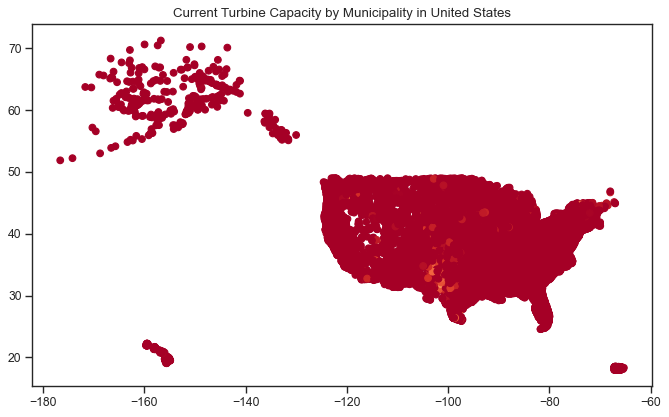

In [19]:
# Plot Towns 
figure(figsize=(10, 6), dpi=80)
plt.scatter(x=towns['xlong'], y=towns['ylat'], c=towns['turbine_capacity'], cmap='RdYlGn')
plt.title(label="Current Turbine Capacity by Municipality in United States")
plt.show()

---
# Elevation

Elevation values are gathered throug the [Open Topo Data Api](https://www.opentopodata.org/). I downloaded the files to host my own API and downloaded the [ETOPO1](https://www.ngdc.noaa.gov/mgg/global/global.html) DEM Dataset to be exposed through the local API. 

## Calculate the Elevation of Each Town

In [20]:
def get_elevation(towns):
    # Data Structure to Store Elevation for Each Town ID
    town_elevations = {
        'town_idx' : [],
        'elevation' : []
    }
    
    # Loop for each Town
    for town_idx, row in towns.iterrows():
        # Make call to Local-hosted API with Geo-Spatial Data
        response = requests.get(f"http://localhost:5000/v1/etopo1?locations={row.ylat},{row.xlong}").json()
        town_elevation = response['results'][0]['elevation']
        
        # Append to Saved Data Structure
        town_elevations['town_idx'].append(town_idx)
        town_elevations['elevation'].append(town_elevation)
        
    # Return Elevations for each Town
    return town_elevations
        

In [21]:
def set_elevation(towns, elevation_data):
    # Set Default Elevation
    towns['elevation'] = 0.0
    
    # Loop for each Town
    for town_idx, row in towns.iterrows():
        # Set the Town's Elevation to the Cached Value
        towns.loc[[town_idx], 'elevation'] = elevation_data.loc[[town_idx], 'elevation']
        

In [22]:
%%time

# Download the Elevation Data if it Does not Already Exist
if not os.path.isfile(os.path.join("data/Processed/elevation.csv")):
    print(f"Downloading Elevation Data from API...")
    # Download Elevation for Each Town
    town_elevation = get_elevation(towns)
    # Convert Elevation Data to DataFrame 
    elevation_df = pd.DataFrame.from_dict(town_elevation)
    # Save DF to CSV as Cache to Improve Performance
    elevation_df.to_csv("./data/Processed/elevation.csv")
else:
    print(f"Reading Cached Elevation Data from API...")
    # Load the DF from Cached CSV to Improve Performance
    elevation_df = pd.read_csv("./data/Processed/elevation.csv")
    

# Set the Elevation
set_elevation(towns=towns, elevation_data=elevation_df)

Reading Cached Elevation Data from API...
CPU times: user 59.1 s, sys: 1.31 s, total: 1min
Wall time: 1min 4s


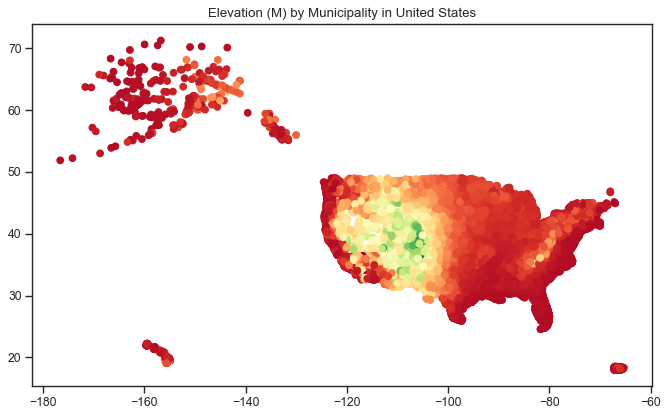

In [23]:
# Plot Towns 
figure(figsize=(10, 6), dpi=80)
plt.scatter(x=towns['xlong'], y=towns['ylat'], c=towns['elevation'], cmap='RdYlGn')
plt.title(label="Elevation (M) by Municipality in United States")
plt.show()

## Calculate Average Elevation Change Between Towns

In [24]:
%%time

# Set Default Elevation Change
towns['avg_elevation_change'] = 0.0

# Loop for each Town
for town_idx, row in towns.iterrows():
    # Get the Neigbors for each Town
    neighbor_idxs = row['neighbors'].split('|')
    neighbors = towns.iloc[neighbor_idxs]
    
    # Store Difference in Elevation for each Town
    elevation_changes = []

    # Loop foreach Neighbor
    for idx_town, elevation  in neighbors[['elevation']].itertuples():
        elevation_change = abs(row['elevation'] - elevation)
        # Add to Lists
        elevation_changes.append(elevation_change)
        
    # Average the Elevation Changes for all Neighbors
    avg_elevation_change = mean(elevation_changes)
    
    # Set Average the Elevation Change
    towns.loc[[town_idx], 'avg_elevation_change'] = avg_elevation_change

CPU times: user 1min 16s, sys: 1.34 s, total: 1min 17s
Wall time: 1min 20s


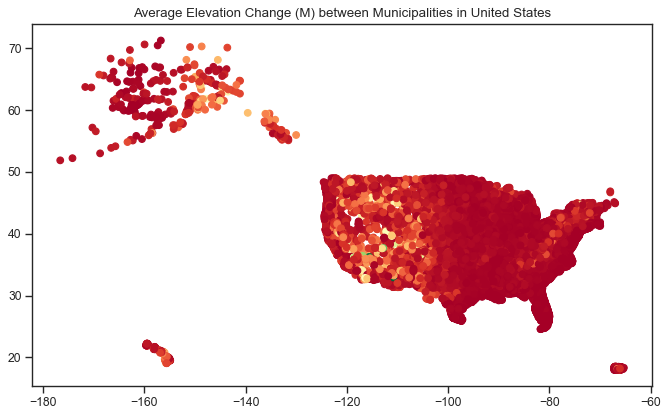

In [25]:
# Plot Towns 
figure(figsize=(10, 6), dpi=80)
plt.scatter(x=towns['xlong'], y=towns['ylat'], c=towns['avg_elevation_change'], cmap='RdYlGn')
plt.title(label="Average Elevation Change (M) between Municipalities in United States")
plt.show()

---
# Weather Data

From [Meteostat](https://meteostat.net/en/)

In [26]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Point, Daily


In [27]:
def get_weather(towns):
    # Data Structure to Store Elevation for Each Town ID
    town_weather = pd.DataFrame(
        columns = ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun'],
        index = towns.index.tolist()
    )
    
    # Loop for each Town
    for town_idx, row in towns.iterrows():
        # Set Timeframe and Location
        start = datetime(2021, 1, 1)
        end = datetime(2021, 12, 31)
        
        # Create Point for Vancouver, BC
        location = Point(row.ylat, row.xlong, row.elevation)
        location.radius = 200000 # 200 KM
        location.alt_range = 100000 # 100 KM
        
        # Make call to Weatehr API
        data = Daily(location, start, end)
        data = data.normalize()
        data = data.interpolate()
        data = data.aggregate('1Y')
        data = data.fetch()
        
        # Append to Saved Data Structure
        town_weather.loc[town_idx] = data.values[0]
    
    # Return Elevations for each Town
    return town_weather
        

In [28]:
%%time

# Download the Weather Data if it Does not Already Exist
if not os.path.isfile(os.path.join("data/Processed/weather.csv")):
    print(f"Downloading Weather Data from API...")
    # Download Weather for Each Town
    weather_df = get_weather(towns)
    # Save DF to CSV as Cache to Improve Performance
    weather_df.to_csv("./data/Processed/weather.csv")
else:
    print(f"Reading Cached Weather Data from API...")
    # Load the DF from Cached CSV to Improve Performance
    weather_df = pd.read_csv("./data/Processed/weather.csv")
    

# Set the Weather Data
towns = towns.join(weather_df)

Reading Cached Weather Data from API...
CPU times: user 28.1 ms, sys: 8.2 ms, total: 36.3 ms
Wall time: 36 ms


In [29]:
# Columns ['snow', 'wpgt'] have Null Data
null_cols = ['snow', 'wpgt']

# Fill Each Null Value with Mean for Given Column
for col_name in null_cols:
    towns[col_name].fillna(value=towns[col_name].mean(), inplace=True)

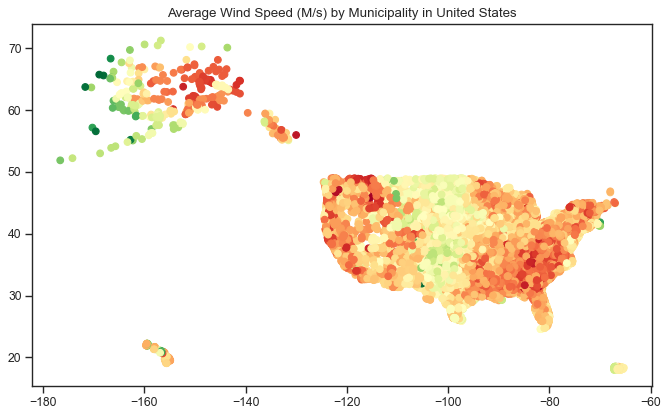

In [30]:
# Plot Towns 
figure(figsize=(10, 6), dpi=80)
plt.scatter(x=towns['xlong'], y=towns['ylat'], c=towns['wspd'], cmap='RdYlGn')
plt.title(label="Average Wind Speed (M/s) by Municipality in United States")
plt.show()

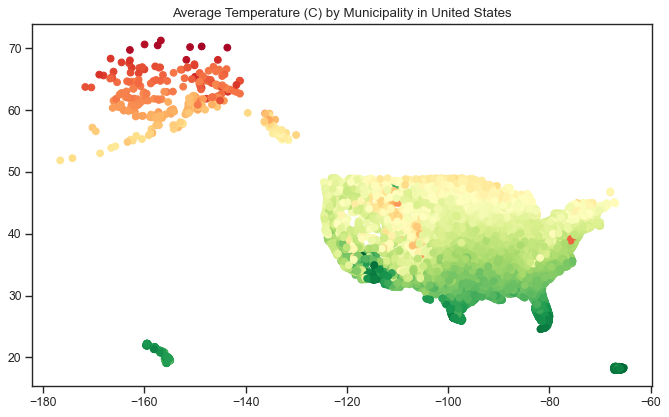

In [31]:
# Plot Towns 
figure(figsize=(10, 6), dpi=80)
plt.scatter(x=towns['xlong'], y=towns['ylat'], c=towns['tavg'], cmap='RdYlGn')
plt.title(label="Average Temperature (C) by Municipality in United States")
plt.show()

---
# House Price Indices

From [Feder Housing Finance Agency](https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx#qpo)

In [32]:
hpi = pd.read_csv("./data/FHFA_HPI/hpi.csv")

display(hpi.head())

,State,Abbreviation,FIPS,Year,Annual Change (%),HPI,HPI with 1990 base,HPI with 2000 base
0,Alabama,AL,1,1975,NaN,100.00,50.00,36.45
1,Alabama,AL,1,1976,5.92,105.92,52.96,38.61
2,Alabama,AL,1,1977,10.21,116.73,58.37,42.55
3,Alabama,AL,1,1978,8.22,126.33,63.17,46.05
4,Alabama,AL,1,1979,11.16,140.42,70.22,51.19


In [33]:
state_stats = {
    'state_id' : [],
    'mean_annual_hpi_pct_change': [],
    'mean_HPI' : [],
    'mean_HPI_1990_base' : [],
    'mean_HPI_2000_base': []
}

In [34]:
for state in hpi.Abbreviation.unique():
    state_hpi_records = hpi[hpi['Abbreviation'] == state]
    
    state_stats['state_id'].append( state_hpi_records['Abbreviation'].values[0])
    state_stats['mean_annual_hpi_pct_change'].append(state_hpi_records['Annual Change (%)'].mean())
    state_stats['mean_HPI'].append(state_hpi_records['HPI'].mean())
    state_stats['mean_HPI_1990_base'].append(state_hpi_records['HPI with 1990 base'].mean())
    state_stats['mean_HPI_2000_base'].append(state_hpi_records['HPI with 2000 base'].mean())

# Create DataFrame for House Price Index by State
hpi_agg = pd.DataFrame.from_dict(state_stats)

In [35]:
# Merge with Data for Towns
#     note: - this removes Puerto Rico since it is not supported in the HPI dataset
towns = towns.merge(hpi_agg, how='left', on='state_id')

# Fill Null values based on Estimations from other States
cols = ['mean_annual_hpi_pct_change', 'mean_HPI', 'mean_HPI_1990_base', 'mean_HPI_2000_base']
for col in cols:
    towns[col].fillna(value=towns[col].mean(), inplace=True)

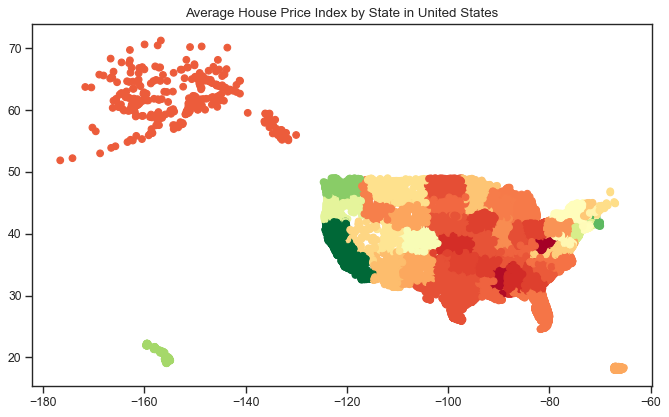

In [36]:
# Plot Towns 
figure(figsize=(10, 6), dpi=80)
plt.scatter(x=towns['xlong'], y=towns['ylat'], c=towns['mean_HPI'], cmap='RdYlGn')
plt.title(label="Average House Price Index by State in United States")
plt.show()

---
# Export Cleaned Data for Analysis

In [37]:
# Show Cleaned Data
display(towns.head())
towns.to_csv("./Data/Processed/towns.csv")

,city,state_id,ylat,xlong,population,density,neighbors,state_wind_gen_MWh,turbine_count,turbine_capacity,...,snow,wdir,wspd,wpgt,pres,tsun,mean_annual_hpi_pct_change,mean_HPI,mean_HPI_1990_base,mean_HPI_2000_base
0,New York,NY,40.6943,-73.9249,18713220,10715,18|34|19|4192,4.521726e+06,0.0,0.0,...,430.000000,286.1,15.0,164.028324,1016.7,0.0,4.736222,408.705435,124.751304,102.252609
1,Los Angeles,CA,34.1139,-118.4068,12750807,3276,1457|1342|447|1253,1.358309e+07,0.0,0.0,...,193.201874,146.1,8.9,164.028324,1014.3,0.0,6.218222,601.786087,128.341739,108.386304
2,Chicago,IL,41.8373,-87.6862,8604203,4574,577|5614|17140|919,1.622594e+07,0.0,0.0,...,660.000000,239.0,15.5,164.028324,1016.9,0.0,3.605333,314.311957,124.466957,88.349783
3,Miami,FL,25.7839,-80.2102,6445545,5019,2751|3414|20429|522,1.481541e+07,0.0,0.0,...,230.000000,92.2,12.3,164.028324,1017.6,0.0,4.406000,301.177609,145.260870,108.313043
4,Dallas,TX,32.7936,-96.7662,5743938,1526,4469|1923|7430|1922,9.244100e+07,0.0,0.0,...,100.000000,145.8,13.3,164.028324,1016.2,0.0,3.921556,278.009348,139.319348,103.157609


In [38]:
print("Preprocessing Time :  %s seconds " % (time.time() - processing_time))

Preprocessing Time :  655.6679310798645 seconds 


---
# Analysis

In [39]:
# Load Towns Data from PreProcessing
towns = pd.read_csv("./data/Processed/towns.csv")

## Measure Correlation to Turine Capacity

In [40]:
# Select the Columns Needed for Analysiz
df = towns[['population','density', 'state_wind_gen_MWh', 'turbine_count',
       'turbine_capacity', 'elevation', 'avg_elevation_change',
       'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'mean_annual_hpi_pct_change', 'mean_HPI', 'mean_HPI_1990_base',
       'mean_HPI_2000_base']]

# Normalize Data
df=(df-df.mean())/df.std()

In [41]:
# Meaure Correlations With Target Column
correlations = df.corrwith(df['state_wind_gen_MWh']) 

# Compute the Absolute Value of the Correlation
corrs = np.absolute(correlations.values)

# Reverse sort, numpy array negation reverses the order
ranks = np.argsort((-corrs))

# Display top-9 and bot-5
rankings = np.array([(f'{corrs[j]:.5f}', df.columns[j]) for j in ranks])
display(rankings)

array([['1.00000', 'state_wind_gen_MWh'],
       ['0.39713', 'tavg'],
       ['0.34760', 'wdir'],
       ['0.19382', 'wspd'],
       ['0.19251', 'mean_HPI'],
       ['0.16808', 'tmax'],
       ['0.16643', 'mean_HPI_2000_base'],
       ['0.11516', 'mean_annual_hpi_pct_change'],
       ['0.10943', 'avg_elevation_change'],
       ['0.10558', 'turbine_capacity'],
       ['0.10471', 'pres'],
       ['0.08814', 'elevation'],
       ['0.07952', 'turbine_count'],
       ['0.07140', 'mean_HPI_1990_base'],
       ['0.03679', 'density'],
       ['0.02333', 'tsun'],
       ['0.01418', 'snow'],
       ['0.01205', 'prcp'],
       ['0.00933', 'tmin'],
       ['0.00384', 'population'],
       ['0.00080', 'wpgt']], dtype='<U26')

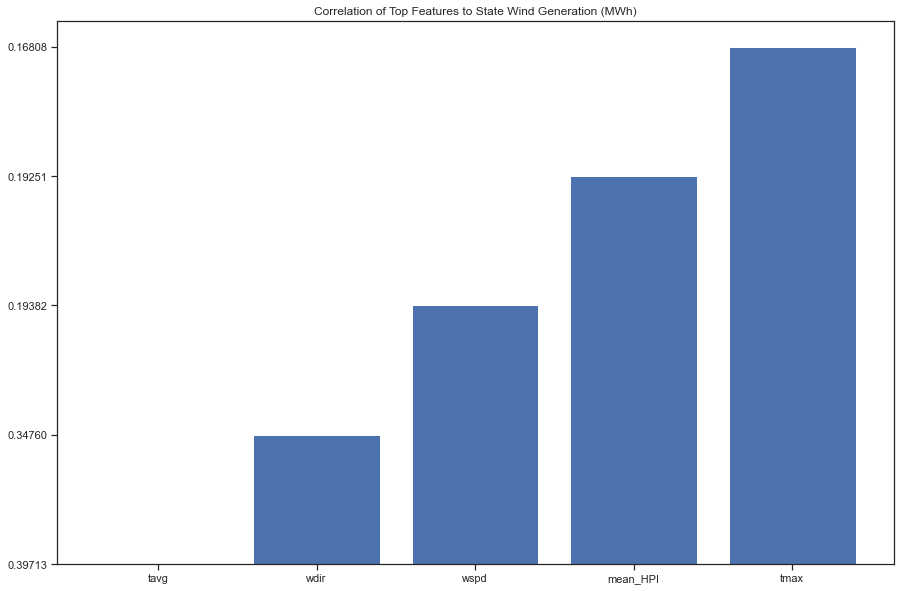

In [42]:
# Plot the Rankings based on Correlations
plt.figure(figsize=(15,10))
plt.bar(rankings[1:6,1], rankings[1:6,0])
plt.title(label="Correlation of Top Features to State Wind Generation (MWh)")
plt.show()

## Applying Machine Learning

In [43]:
# Prepare the input X matrix and target y vector
X = df.loc[:, df.columns != 'state_wind_gen_MWh'].values
y = df.loc[:, df.columns == 'state_wind_gen_MWh'].values.ravel()
print(f'X Shape: {X.shape}')
print(f'y Shape: {y.shape}')

# Create a new Dataframe to Store Results
results = pd.DataFrame()


X Shape: (28337, 20)
y Shape: (28337,)


### Unsupervised Clustering

In [44]:
# Measure Experiment Time
unsupervised_time = time.time()

In [45]:
%%time
from sklearn.cluster import KMeans

# See how the Number of Clusters helps Separate the Data
for num_clusters in range(10, 100, 20):
    # Sort the Data into N Clusters
    experiment_name = f"kmeans_{num_clusters}"
    df[experiment_name] = KMeans(n_clusters=num_clusters, n_init=50, max_iter=300, tol=1e-4).fit_predict(X)

    # Add Exporimental Results
    results[[experiment_name]] = df[[experiment_name]]

CPU times: user 7min 28s, sys: 51.3 s, total: 8min 19s
Wall time: 1min 20s


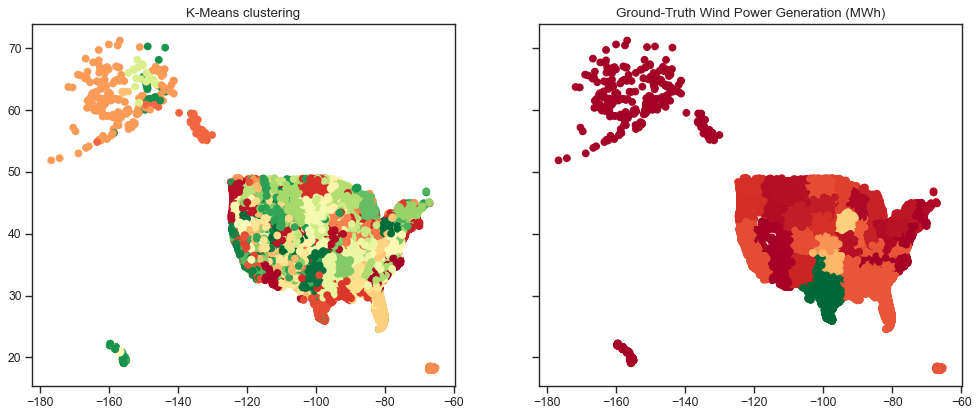

In [46]:
# Plot Towns 
f, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 6), dpi=80)
axes[0].scatter(x=towns['xlong'], y=towns['ylat'], c=results[experiment_name], cmap='RdYlGn')
axes[0].title.set_text("K-Means clustering")
axes[1].scatter(x=towns['xlong'], y=towns['ylat'], c=df['state_wind_gen_MWh'], cmap='RdYlGn')
axes[1].title.set_text("Ground-Truth Wind Power Generation (MWh)")
plt.show()

In [47]:
%%time
from sklearn.cluster import DBSCAN

# Define Min Samples
min_samples=2*X.shape[-1]

# See how the Size of Clusters helps Separate the Data
for cutoff in [x / 10.0 for x in range(2, 10, 2)]:
    # Sort the Data into N Clusters
    experiment_name = f"DBSCAN_{cutoff}"
    df[experiment_name] = DBSCAN(eps=cutoff, min_samples=min_samples).fit_predict(X)

    # Add Exporimental Results
    results[[experiment_name]] = df[[experiment_name]]

CPU times: user 43.5 s, sys: 12.1 s, total: 55.6 s
Wall time: 28 s


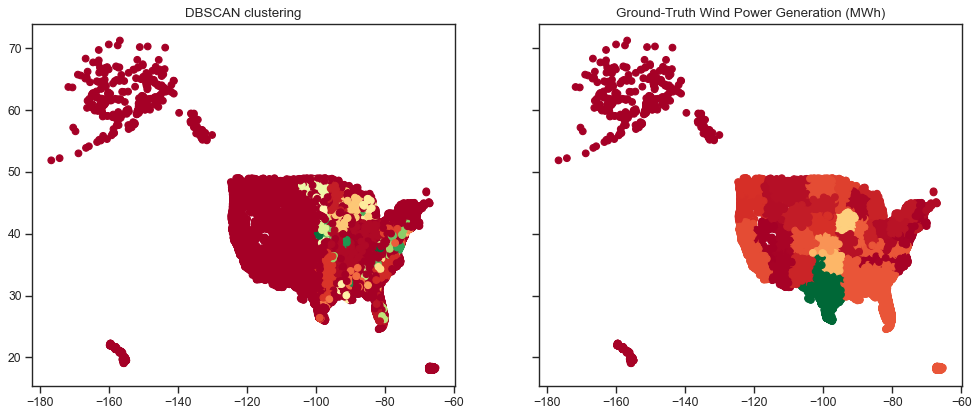

In [48]:
# Plot Towns 
f, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 6), dpi=80)

axes[0].scatter(x=towns['xlong'], y=towns['ylat'], c=results[experiment_name], cmap='RdYlGn')
axes[0].title.set_text("DBSCAN clustering")

axes[1].scatter(x=towns['xlong'], y=towns['ylat'], c=df['state_wind_gen_MWh'], cmap='RdYlGn')
axes[1].title.set_text("Ground-Truth Wind Power Generation (MWh)")

plt.show()

In [49]:
print("Unsupervised Experiment Time :  %s seconds " % (time.time() - unsupervised_time))

Unsupervised Experiment Time :  110.63625597953796 seconds 


### Supervised Learning

In [50]:
# Measure Experiment Time
supervised_time = time.time()

In [51]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

def evaluate_kfold(_X, _y, model, folds=5):
    accuracies = []
    # Set up Validation
    kf = KFold(n_splits=folds, shuffle=True, random_state=12)
    for train, test in kf.split(_X, _y):
        # Fit them to the Split Data
        model.fit(_X[train], _y[train])
        # Make Predictions on Each Model
        pred = model.predict(_X[test])
        # Calculate the Accuracy
        acc = mean_squared_error(_y[test], pred, squared=False)
        accuracies.append(acc)
    
    # Make final Prediction on Regression
    preds = model.predict(_X)
    
    return np.array(accuracies), preds

In [52]:
%%time
from sklearn.svm import SVR

model = SVR()
scores, preds = evaluate_kfold(X, y, model)

# Add Exporimental Results
experiment_name = 'SVR'
results[[experiment_name]] = preds
print(f'5-fold cross validation RMSE {np.mean(scores):.3f} {chr(177)}{np.std(scores):.4f}')

5-fold cross validation RMSE 0.265 ±0.0077
CPU times: user 2min 31s, sys: 1.42 s, total: 2min 32s
Wall time: 2min 33s


In [53]:
%%time
from sklearn.linear_model import LinearRegression

model = LinearRegression()
scores, preds = evaluate_kfold(X, y, model)

# Add Exporimental Results
experiment_name = 'LinearRegression'
results[[experiment_name]] = preds
print(f'5-fold cross validation RMSE {np.mean(scores):.3f} {chr(177)}{np.std(scores):.4f}')

5-fold cross validation RMSE 0.792 ±0.0118
CPU times: user 159 ms, sys: 10.1 ms, total: 169 ms
Wall time: 59.2 ms


In [54]:
%%time
from sklearn.linear_model import SGDRegressor

model = SGDRegressor()
scores, preds = evaluate_kfold(X, y, model)

# Add Exporimental Results
experiment_name = 'SGDRegressor'
results[[experiment_name]] = preds
print(f'5-fold cross validation RMSE {np.mean(scores):.3f} {chr(177)}{np.std(scores):.4f}')

5-fold cross validation RMSE 0.795 ±0.0111
CPU times: user 909 ms, sys: 34 ms, total: 943 ms
Wall time: 249 ms


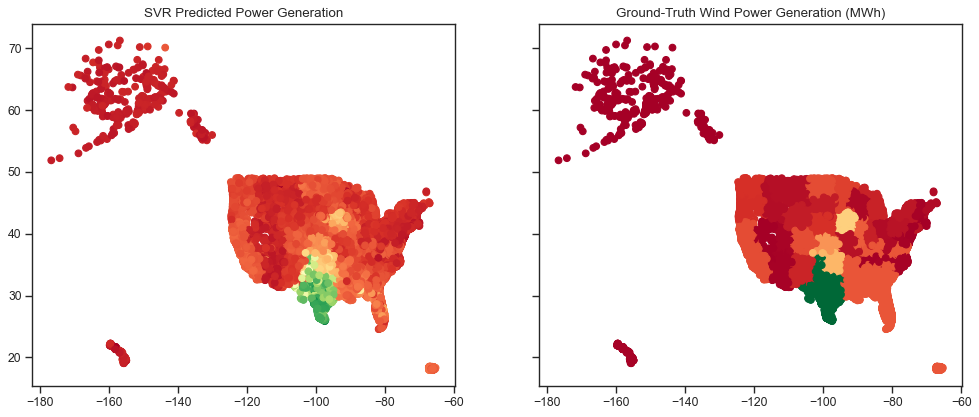

In [55]:
# Plot Towns 
f, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 6), dpi=80)

axes[0].scatter(x=towns['xlong'], y=towns['ylat'], c=results['SVR'], cmap='RdYlGn')
axes[0].title.set_text("SVR Predicted Power Generation")

axes[1].scatter(x=towns['xlong'], y=towns['ylat'], c=df['state_wind_gen_MWh'], cmap='RdYlGn')
axes[1].title.set_text("Ground-Truth Wind Power Generation (MWh)")
plt.show()

In [56]:
print("Supervised Experiment Time :  %s seconds " % (time.time() - supervised_time))

Supervised Experiment Time :  155.48428797721863 seconds 


## Machine Learning Results

In [57]:
# Normalize Data
results=(results-results.mean())/results.std()

# Meaure Correlations With Target Column
correlations = results.corrwith(towns['state_wind_gen_MWh']) 

# Compute the Absolute Value of the Correlation
corrs = np.absolute(correlations.values)

# Reverse sort, numpy array negation reverses the order
ranks = np.argsort((-corrs))

# Display top-9 and bot-5
rankings = np.array([(f'{corrs[j]:.5f}', results.columns[j]) for j in ranks])


In [58]:
rankings

array([['0.96972', 'SVR'],
       ['0.61183', 'LinearRegression'],
       ['0.60913', 'SGDRegressor'],
       ['0.27969', 'kmeans_10'],
       ['0.08836', 'kmeans_30'],
       ['0.06381', 'kmeans_90'],
       ['0.03677', 'DBSCAN_0.6'],
       ['0.03457', 'kmeans_70'],
       ['0.01429', 'kmeans_50'],
       ['0.01228', 'DBSCAN_0.4'],
       ['0.00731', 'DBSCAN_0.8'],
       ['nan', 'DBSCAN_0.2']], dtype='<U16')

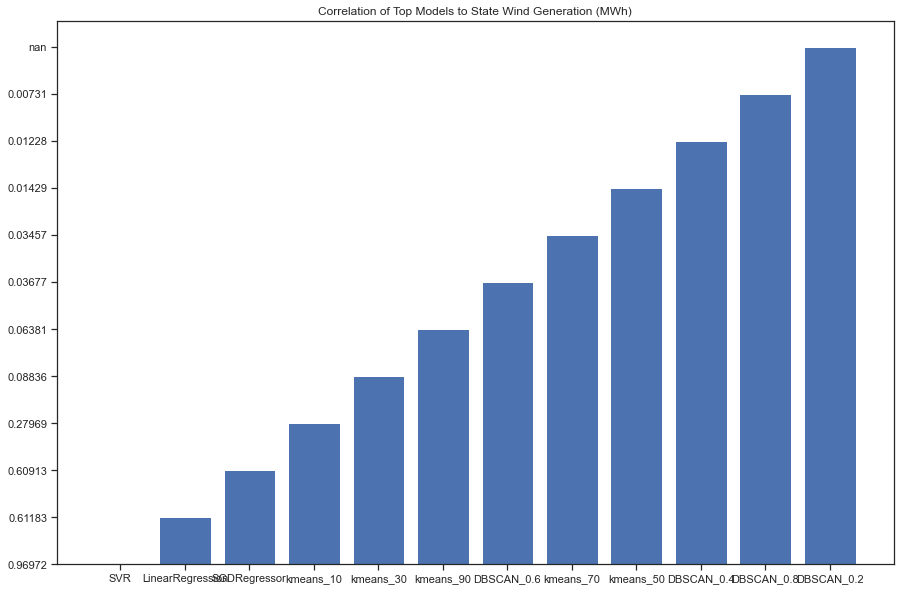

In [59]:
# Plot the Rankings based on Correlations
plt.figure(figsize=(15,10))
plt.bar(rankings[:,1], rankings[:,0])
plt.title(label="Correlation of Top Models to State Wind Generation (MWh)")
plt.show()